# Yolov4 Inference



# Cloning the NHD Colab Repos

The following cell determines whether you are running in colab and if the git repos should be cloned. 
Just copy and past this cell as is


In [ ]:
%%bash
if [  -d "/content/nhd-colab" ]
then
   echo "Environment already initialized"
elif [ -d "/content" ] && [ ! -d "/content/nhd-colab" ]
then
    cd /content || exit 1;
    echo "Installing https://github.com/nhdchicken/nhd-colab.git"
    git clone --recurse-submodules https://github.com/nhdchicken/nhd-colab.git || exit 1;
    cd nhd-colab || exit 1;
    pip install utils/nhdcolab > /dev/null 2>&1 || exit 1;
else
    echo "Not running in Colab - going to root of repos"
    cd `git rev-parse --show-toplevel` || exit 1;
    pip install -e utils/nhdcolab > /dev/null 2>&1 || exit 1;
fi
nhdcolab > /dev/null 2>&1 || exit 1;
echo "Great Success!"

# Component Installation

The next cell initializes the components by running the commands specified in the [install.yaml](../install.yaml)
as well as the patches required. I not patch group is specified, all patch groups are installed. To disable patching
use --no-patch


In [ ]:
!nhdcolab init yolov4-tf --force

# Loading the Environment

This piece of code loads the NHD environment into your notebook. From that object, you can access various environment variables. 

If running in Colab, and if _gdrive_mount_ is True, the google drive will be mounted. On your workstation, 
it will look at _NHD_ENV.NHD_COLAB_REPOS_ROOT / 'drive' / 'nhddrive'_. 

You can however override this by setting the _NHD_COLAB_DRIVE_ environment variable to the data location. 

For instance, say your Box storage is under ~/Box/NHD/nhddrive, you can set _NHD_COLAB_DRIVE_ to that location.


In [5]:
from nhdcolab.environment import NHDEnvironment
NHD_ENV = NHDEnvironment(gdrive_mount=True)


NHD_COLAB_REPOS_ROOT=/Users/lpbrac/gitlab/pyops/nhd/nhd-colab OK!
Google drive not mounted since not running in Colab - using /Users/lpbrac/gitlab/pyops/nhd/nhd-colab/drive/nhddrive


# YoloDetector

In [6]:
import os
import sys
import click
import tensorflow as tf
ROOT_DIR = os.path.join(NHD_ENV.NHD_COLAB_REPOS_ROOT, "yolov4", "tensorf")
sys.path.append(ROOT_DIR)  # To find local version of the library
from core.config import cfg
import core.utils as utils
from core.yolov4 import YOLOv4, YOLOv3, YOLOv3_tiny, decode
import numpy as np


class YoloV4Detector:

    def __init__(self, tiny=False, version=4, quant='fp16', use_tflite=False, input_size=608, weights='yolov4.weights'):
        click.secho(f"version={version} tiny={tiny} quant={quant}", fg='cyan')
        assert weights, "Weights filename required"
        self.weights = NHD_ENV.NHD_COLAB_MODEL_ROOT / 'yolov4' / weights

        assert self.weights.is_file(), f"weights {self.weights} not found"

        self.strides = None
        self.anchors = None
        self.tiny = tiny
        self.yolo_version = version
        if tiny:
            self.strides = np.array(cfg.YOLO.STRIDES_TINY)
            self.anchors = utils.get_anchors(cfg.YOLO.ANCHORS_TINY, tiny)
        else:
            self.strides = np.array(cfg.YOLO.STRIDES)
            if version == 4:
                self.anchors = utils.get_anchors(cfg.YOLO.ANCHORS, tiny)
            else:
                self.anchors = utils.get_anchors(cfg.YOLO.ANCHORS_V3, tiny)

        self.num_classes = len(utils.read_class_names(cfg.YOLO.CLASSES))
        self.xyscale = cfg.YOLO.XYSCALE
        self.use_tflite = use_tflite
        self.input_size = input_size
        self._model = None
        self._input_layer = None

    @property
    def input_layer(self):
        if self._input_layer is None:
            click.secho(f"creating input layer {self.input_size} {self.input_size} {3}", fg='green')
            self._input_layer = tf.keras.layers.Input([self.input_size, self.input_size, 3])
        return self._input_layer

    @property
    def model(self):
        if self._model is None:
            if self.tiny:
                raise NotImplementedError("Not yet there")
            else:
                if self.yolo_version == 3:
                    raise NotImplementedError("YoloV3 not there yet")
                elif self.yolo_version == 4:
                    feature_maps = YOLOv4(self.input_layer, self.num_classes)
                    bbox_tensors = []
                    for i, fm in enumerate(feature_maps):
                        bbox_tensor = decode(fm, self.num_classes, i)
                        bbox_tensors.append(bbox_tensor)
                    self._model = tf.keras.Model(self.input_layer, bbox_tensors)
                    if self.weights.suffix == '.weights':
                        utils.load_weights(self._model, str(self.weights))
                    else:
                        self._model.load_weights(str(self.weights)).expect_partial()
                else:
                    raise ValueError(f"Invalid yolo version {self.yolo_version}")
            self._model.summary()
        return self._model

    def search(self, frame):
        image_data = utils.image_preprocess(np.copy(frame.original), [self.input_size, self.input_size])
        image_data = image_data[np.newaxis, ...].astype(np.float32)
        frame.model_input_size = self.input_size
        pred_bbox = self.model.predict(image_data)
        if self.yolo_version == 4:
            pred_bbox = utils.postprocess_bbbox(pred_bbox, self.anchors, self.strides, self.xyscale)
        else:
            pred_bbox = utils.postprocess_bbbox(pred_bbox, self.anchors, self.strides)
        bboxes = utils.postprocess_boxes(pred_bbox, frame.original_size, self.input_size, 0.25)
        frame.bboxes = utils.nms(bboxes, 0.213, method='nms')
        utils.draw_bbox(frame.original, frame.bboxes)
        return frame

In [7]:
detector = YoloV4Detector(tiny=False, version=4, quant='fp16', use_tflite=False, input_size=608, weights='yolov4.weights')

version=4 tiny=False quant=fp16


In [8]:
import nhdcolab.sources
frame_source = nhdcolab.sources.FrameSource(NHD_ENV.NHD_COLAB_TEST_MATERIAL / 'coco' / 'images')


In [9]:
import nhdcolab.display
FRAMES = []
for frame in frame_source.next_frame():
    FRAMES.append(detector.search(frame))

extracting frames from 8829708882_48f263491e_z.jpg
creating input layer 608 608 3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 608, 608, 32) 0           batch_normalization[0][0]        
____________

extracting frames from 9247489789_132c0d534a_z.jpg
extracting frames from 3878153025_8fde829928_z.jpg
extracting frames from 6821351586_59aa0dc110_z.jpg
extracting frames from 5951960966_d4e1cda5d0_z.jpg
extracting frames from 3800883468_12af3c0b50_z.jpg
extracting frames from 8512296263_5fc5458e20_z.jpg
extracting frames from 2516944023_d00345997d_z.jpg
extracting frames from 8734543718_37f6b8bd45_z.jpg
extracting frames from 6584515005_fce9cec486_z.jpg
extracting frames from 8699757338_c3941051b6_z.jpg
extracting frames from 2383514521_1fc8d7b0de_z.jpg
extracting frames from 4782628554_668bc31826_z.jpg
extracting frames from 3651581213_f81963d1dd_z.jpg
extracting frames from 3627527276_6fe8cd9bfe_z.jpg
extracting frames from 3862500489_6fd195d183_z.jpg
extracting frames from 8053677163_d4c8f416be_z.jpg
extracting frames from 2502287818_41e4b0c4fb_z.jpg
extracting frames from 12283150_12d37e6389_z.jpg
extracting frames from 8239308689_efa6c11b08_z.jpg
extracting frames from 8433365521

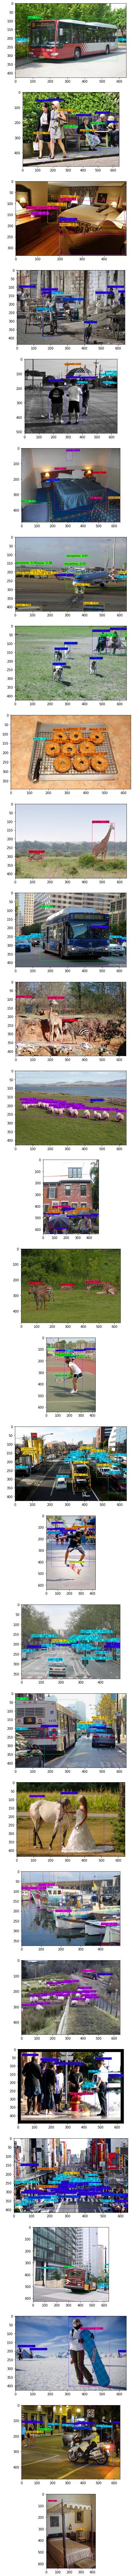

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(150,150))
columns = 1
for i, frame in enumerate(FRAMES):
    plt.subplot(len(FRAMES) / columns + 1, columns, i + 1)
    plt.imshow(frame.original)